# QuanEstimation : Learning test

The Hamiltonian of a controlled system is $H = v_y \sigma_y + v_z \sigma_z$, where $v_y$, $v_z$ the control sequence 
and $\sigma_{y(z)}$ the Pauli matrix.

Consider unitary dynamics with the initial state $\rho=|+\rangle \langle+|$.

In this script, we will calculate the fidelity of the system with DDPG algorithm, the fidelity can be written as 
$F(t) = \mathrm {Tr} \left(\sqrt{\sqrt{\rho_t}\rho_0 \sqrt{\rho_t}}\right)$

In [1]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
import torch
from qutip import *

from test_learning_env import env
from Control.Learning import DDPG

omega0 = 1.0
T = 30.0
tnum = 1000
#tspan = np.linspace(0, T, tnum)
#dt = tspan[1]-tspan[0]
dt = 0.01

sx = np.array([[0,1],[1,0]])  
sy = np.array([[0,-1j],[1j,0]]) 
sz = np.array([[1,0],[0,-1]])
sp, sm = 0.5*(sx+1j*sy), 0.5*(sx-1j*sy)

#initial state
psi0 = np.array([[1],[0]])
psi1 = np.array([[0],[1]])
psi_p = (psi0+psi1)/np.sqrt(2)
psi_m = (psi0-psi1)/np.sqrt(2)
rho0 = np.dot(psi_p, psi_p.conj().T)
dim = rho0.shape[0]

#time independent Hamiltonian
H0 = 0.5*omega0*sz
dH0 = [0.5*sz]

#control Hamiltonian
Hc = [sx,sy,sz]

#Liouville operator
Lvec = [sz]
gamma = [0.05]

#measurement
M1 = np.dot(psi_p, psi_p.conj().transpose())
M2 = np.dot(psi_m, psi_m.conj().transpose())
M  = [M1, M2]

#================================================
ctrl_interval = dt
action_bound = 5.0 # the boundary value of action
var = 3.4  # control exploration
seed = 200
max_episodes = 300
max_ep_steps = int(T/ctrl_interval)

np.random.seed(seed)
torch.manual_seed(seed)

env = env(dt, H0, Hc, dH0, Lvec, gamma, M) 
a_dim = env.ctrl_num
s_dim = 2*dim**2

ddpg = DDPG(a_dim, s_dim, action_bound, actor_hidn_dim=150, critic_hidn_dim=150, actor_layer=2, critic_layer=0,\
            buffer_capacity=50*int(T/ctrl_interval), batch_size=32, gamma=0.95, tau=0.02, actor_lr=0.001, critic_lr=0.002)

Reward, Action_all, QFI = [], [], []
for episode in range(max_episodes):
    state = env.input_state(rho0)
    drho = np.array([np.zeros(dim**2)]).T
    ep_reward = 0
    
    Action = []
    for ti in range(max_ep_steps):
        t = ctrl_interval*ti
        action = ddpg.choose_action(state)
        action = np.random.normal(action, var)
        
        state_, drho_, reward, F_q = env.step([1.0,1.0,1.0], state, drho)
        ddpg.store_transition(state, action, reward/10, state_)
        
        if ddpg.pointer > ddpg.buffer_capacity:
            var *= .999 
            ddpg.learn()
        state = state_
        drho = drho_
        ep_reward += reward
        
        Action.append(action)

    Reward.append(ep_reward)
    Action_all.append(Action)
    
    print('Episode:', episode, F_q)
    
np.save('reward', Reward)
np.save('action', Action_all)
np.save('fidelity', QFI)

# reward

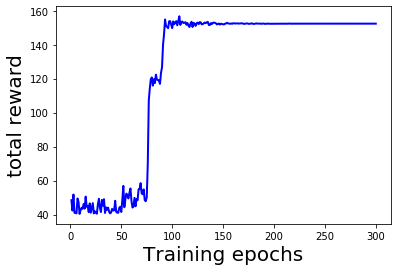

In [2]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt

R = np.load('reward.npy')

Rnum = len(R)
total_R = R.reshape(1,Rnum)[0]
plt.plot(np.linspace(1,Rnum,Rnum),total_R,'b-',linewidth=2.0)

plt.xlabel('Training epochs',fontsize=20)
plt.ylabel('total reward',fontsize=20)
plt.show()

# fidelity

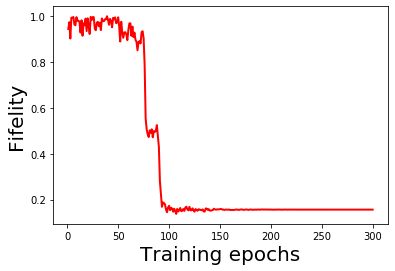

In [3]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt

F = np.load('fidelity.npy')

Fnum = len(F)

plt.plot(np.linspace(1,Fnum,Fnum),F,'r-',linewidth=2.0)

plt.xlabel('Training epochs',fontsize=20)
plt.ylabel('Fifelity',fontsize=20)
plt.show()

# control sequence

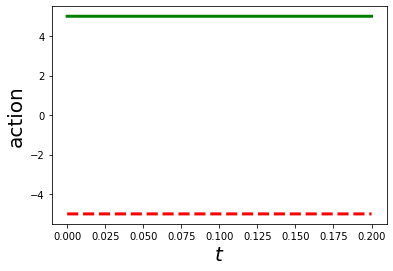

In [4]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt

from test_learning_env import env

T = 0.2
dt = 0.0005
tnum = int(T/dt)
eta = 0.9
ctrl_interval = 0.005
tnum_iteration = 20
action_all = np.load('action.npy')

num = int(tnum/len(action_all[-1][:,0]))

vy = action_all[-1][:,0].repeat(num)
vy = np.concatenate((vy, vy[-1]*np.ones(int(tnum-len(vy)))))

vz = action_all[-1][:,1].repeat(num)
vz = np.concatenate((vz, vz[-1]*np.ones(int(tnum-len(vz)))))

plt.plot(np.linspace(0, T, tnum), vy,'g-',linewidth=3.0)
plt.plot(np.linspace(0, T, tnum), vz,'r--',linewidth=3.0)
plt.xlabel('$t$',fontsize=20)
plt.ylabel('action',fontsize=20)

plt.show()

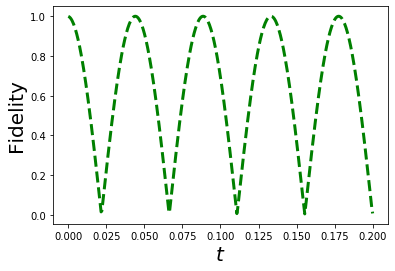

In [5]:
env = env(ctrl_interval, tnum_iteration, eta) 

state = env.input_state(env.rho0.full())
Ft = []
for ti in range(tnum):
    t = dt*ti
    state_, reward, fidelity = env.step(state, [vy[ti],vz[ti]], t)
  
    state = state_
    Ft.append(fidelity)
plt.plot(np.linspace(0, T, tnum), Ft,'g--',linewidth=3.0)
plt.xlabel('$t$',fontsize=20)
plt.ylabel('Fidelity',fontsize=20)
plt.show()